In [1]:
import gzip
import numpy as np
import array
import math
import numba as nb
from numba.typed import List
import matplotlib.pyplot as plt
from tqdm import tqdm
from numba import njit
from scipy.optimize import linear_sum_assignment

In [2]:
def generate_data(m, v):
    unif_value = np.random.uniform(0, 1, 12)
    value = (sum(unif_value)-6)
    return math.sqrt(v)*value + m

In [5]:
inp = input("input N mx1 vx1 my1 vy1 mx2 vx2 my2 vy2 (seperated by space): ")
inp = inp.split()
N = int(inp[0])
mx1 = float(inp[1])
vx1 = float(inp[2])
my1 = float(inp[3])
vy1 = float(inp[4])
mx2 = float(inp[5])
vx2 = float(inp[6])
my2 = float(inp[7])
vy2 = float(inp[8])

input N mx1 vx1 my1 vy1 mx2 vx2 my2 vy2 (seperated by space): 50 1 2 1 2 3 4 3 4


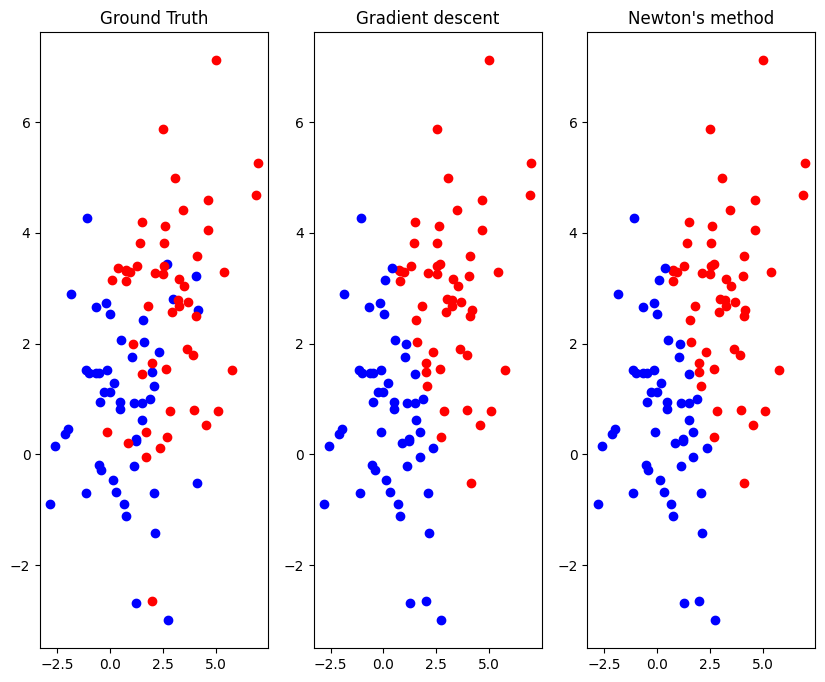

In [6]:
Data = np.ones((2*N,3))
label = np.vstack((np.zeros((N,1)), np.ones((N,1))))
lr = 0.1
max_epoch = 10000
for i in range(N):
    Data[i][0] = 1
    Data[i][1] = generate_data(mx1,vx1)
    Data[i][2] = generate_data(my1,vy1)

    Data[i+N][0] = 1
    Data[i+N][1] = generate_data(mx2,vx2)
    Data[i+N][2] = generate_data(my2,vy2)

w = np.zeros((3,1))
pred = np.zeros((2*N,1))
result = open("Q1_results.txt", 'w')
result.write("Gradient descent:\n\n")
for _ in range(max_epoch):
    grad = np.dot(Data.T, label-1/(1+np.exp(-np.dot(Data,w))))
    w = w + lr * grad
    pred = 1/(1+np.exp(-np.dot(Data,w)))
    pred = np.round(pred)

    CM = np.zeros((2,2))
    for i in range(N):
        if pred[i][0] == label[i][0]:
            CM[0][0] += 1
        else:
            CM[0][1] += 1

        if pred[i+N][0] == label[i+N][0]:
            CM[1][1] += 1
        else:
            CM[1][0] += 1

result.write(f"w:\n {w[0][0]} {w[1][0]} {w[2][0]}\n")
result.write("\n\nConfusion Matrix:\n")
result.write("{0:>48}".format("Predict cluster 1 Predict cluster 2\n"))
result.write(f"Is cluster 1 {CM[0][0]:12} {CM[0][1]:12}\n")
result.write(f"Is cluster 2 {CM[1][0]:12} {CM[1][1]:12}\n\n")
result.write(f"Sensitivity (Successfully predict cluster 1): {CM[0][0]/(CM[0][0]+CM[0][1])}\n")
result.write(f"Specificity (Successfully predict cluster 2): {CM[1][1]/(CM[1][0]+CM[1][1])}\n")
result.write("------------------------------------\nNewton's method: \n\n")

w = np.zeros((3,1))
for _ in range(max_epoch):
    grad = np.dot(Data.T, label-1/(1+np.exp(-np.dot(Data,w))))
    try:
        parameter = (np.exp(-np.dot(Data,w)) / ((1 + np.exp(-np.dot(Data,w)))**2)).reshape(Data.shape[0])
        D = np.diag(parameter)
        Hessian_inv = np.linalg.inv(np.dot(Data.T,np.dot(D,Data)))
        grad = Hessian_inv @ grad
    except np.linalg.LinAlgError:
        grad = grad
    w = w + grad
    pred = 1/(1+np.exp(-np.dot(Data,w)))
    pred = np.round(pred)

    CM = np.zeros((2,2))
    for i in range(N):
        if pred[i][0] == label[i][0]:
            CM[0][0] += 1
        else:
            CM[0][1] += 1

        if pred[i+N][0] == label[i+N][0]:
            CM[1][1] += 1
        else:
            CM[1][0] += 1

result.write(f"w:\n {w[0][0]} {w[1][0]} {w[2][0]}\n")
result.write("\n\nConfusion Matrix:\n")
result.write("{0:>48}".format("Predict cluster 1 Predict cluster 2\n"))
result.write(f"Is cluster 1 {CM[0][0]:12} {CM[0][1]:12}\n")
result.write(f"Is cluster 2 {CM[1][0]:12} {CM[1][1]:12}\n\n")
result.write(f"Sensitivity (Successfully predict cluster 1): {CM[0][0]/(CM[0][0]+CM[0][1])}\n")
result.write(f"Specificity (Successfully predict cluster 2): {CM[1][1]/(CM[1][0]+CM[1][1])}\n")
result.close()
fig, axs = plt.subplots(1, 3, figsize=(10, 8))
axs[0].scatter(Data[0:N,1], Data[0:N,2], color='b')
axs[0].scatter(Data[N:2*N,1], Data[N:2*N,2], color='r')
axs[0].set_title('Ground Truth')

for i in range(2*N):
    if pred[i][0] >= 0.5:
        axs[1].scatter(Data[i][1], Data[i][2], color='r')
    else:
        axs[1].scatter(Data[i][1], Data[i][2], color='b')
axs[1].set_title('Gradient descent')

for i in range(2*N):
    if pred[i][0] >= 0.5:
        axs[2].scatter(Data[i][1], Data[i][2], color='r')
    else:
        axs[2].scatter(Data[i][1], Data[i][2], color='b')
axs[2].set_title('Newton\'s method')

fig.show()

In [7]:
# Load the training dataset
image_file = open("/content/train-images.idx3-ubyte", "rb")
magic_number = image_file.read(4) #magic number
num_images = int.from_bytes(image_file.read(4), byteorder='big') #number of images
num_rows = int.from_bytes(image_file.read(4), byteorder='big') #change char to integer
num_columns = int.from_bytes(image_file.read(4), byteorder='big') #change char to integer
image_size = num_rows * num_columns
image = np.zeros((num_images, image_size), dtype=int)

for i in range(num_images):
    for j in range(image_size):
        image[i][j] = int.from_bytes(image_file.read(1), byteorder='big')//128

label_file = open("/content/train-labels.idx1-ubyte", "rb")
magic_number = label_file.read(4) #magic number
num_labels = int.from_bytes(label_file.read(4), byteorder='big') #change char to integer
labels = np.zeros(num_labels, dtype=int)

for i in range(num_labels):
    labels[i] = int.from_bytes(label_file.read(1), byteorder='big')


In [8]:
def E_step(C,P,image):
    w = np.zeros((num_images, 10))
    #avoid underflow, in log scale
    for i in range(num_images):
        for j in range(10):
            w[i][j] = np.log(C[j]) + np.sum(image[i] * np.log(P[j]+1e-10)) + np.sum((1 - image[i]) * np.log(1-P[j]+1e-10))
        w[i] = np.exp(w[i] - max(w[i]))
        w[i] = w[i] / np.sum(w[i])
    return w


def M_step(w,image, N):
    C_ = np.ones(10)
    for i in range(10):
        C_[i] = np.sum(w.T[i]) / N

    P = w.T @ image
    for i in range(10):
        sum = np.sum(w.T[i])
        for j in range(image_size):
            P[i][j] /= sum
    return C_, P

max_epoch = 100
C = np.full((10),0.1)
np.random.seed(42)
P = np.random.rand(10, image_size)
w = np.ones((num_images, 10))

result = open("Q2_results.txt","w")
for itr in tqdm(range(max_epoch)):
    w_ = E_step(C,P,image)
    C_,P_ = M_step(w_,image,num_images)
    error_P = np.sum(abs(P-P_))
    error_C = np.sum(abs(C-C_))
    error_w = np.sum(abs(w-w_))
    w = w_.copy()
    P = P_.copy()
    C = C_.copy()
    # print("\n{}'th iteration, w error: {}, P error: {}, C error: {}".format(itr, error_w,error_P,error_C))
    for i in range(10):
        result.write(f"class {i}:\n")
        for j in range(num_rows):
            for k in range(num_columns):
                if P[i][j*num_columns+k] >=0.5:
                    result.write("1 ")
                else:
                    result.write("0 ")
            result.write("\n")
        result.write("\n")
    result.write(f"No. of Iteration: {itr+1}, Difference: {error_w + error_P + error_C}\n")
    if(error_w + error_P + error_C < 1e-3):
        break

label = np.zeros(10)
for i in labels:
    label[i] += 1

distribution=np.zeros((10,784))
for i in range(60000):
    c=labels[i]
    for j in range(784):
        if image[i,j]==1:
            distribution[c,j]+=1

distribution = distribution / label.reshape(-1,1)

Cost=np.zeros((10,10))
for i in range(10):
    for j in range(10):
        Cost[i,j] = np.linalg.norm(distribution[i]-P[j])

_, Label2Group = linear_sum_assignment(Cost)
Group2Label = np.zeros((10))
for i in range(10):
    Group2Label[i] = int(np.where(Label2Group == i)[0][0])
for lab in range(10):
    result.write(f"\nlabeled class {lab}:\n")
    for j in range(num_rows):
        for k in range(num_columns):
            if P[Label2Group[lab]][j*num_columns+k] >=0.4:
                result.write("1 ")
            else:
                result.write("0 ")
        result.write("\n")
    result.write("\n")
result.write("\n-------------------------------------------------------------")
result.write("\n-------------------------------------------------------------\n\n")
error_count = 0
correct_count = 0
for i in range(10):
    CM = np.zeros((2,2))
    for j in range(num_images):
        pred_label = Group2Label[np.argmax(w[j])]
        if labels[j] == i:
            if labels[j] == pred_label:
                CM[0][0] += 1
                correct_count += 1
            else:
                CM[0][1] += 1
                error_count += 1
        else:
            if i != pred_label:
                CM[1][1] += 1
            else:
                CM[1][0] += 1
    result.write(f"Confusion matrix {i}:\n")
    result.write(f"                Predict number {i}   Predict not number {i}\n")
    result.write(f"Is number {i}   {CM[0][0]:15}   {CM[0][1]:15}\n")
    result.write(f"Isn't number {i} {CM[1][0]:14}   {CM[1][1]:15}\n\n")
    result.write(f"Sensitivity (Successfully predict cluster 1): {CM[0][0]/(CM[0][0]+CM[0][1])}\n")
    result.write(f"Specificity (Successfully predict cluster 2): {CM[1][1]/(CM[1][0]+CM[1][1])}\n\n")
    result.write("\n-------------------------------------------------------------\n\n")


result.write(f"Total iteration to converge: {itr+1}\n")
result.write("Total error rate: {}".format(error_count/(error_count+correct_count)))
result.close()

100%|██████████| 100/100 [51:58<00:00, 31.18s/it]
